# Task 1

Implement a bootstrap filter, and the exact filter proposed in this paper, and compare them (in the spirit of Figure 1, i.e. you can compare likelihood profiles like in this figure, or filtering distributions). You can do this comparison on simulated data (so that you know what the exact parameter values, since you
choose them yourself.)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import poisson, nbinom
from tqdm import tqdm


# particles library usage 
import particles
import particles.state_space_models as ssm
import particles.distributions as dists


# project related packages
import utils.cox_simulation as cx
import utils.plots as pl
import utils.creal_filter as cf 
import utils.particle_filter as pf
#import utils.particle_v1 as pf1

## Data simulation

In [43]:
# Simulation des données selon modèle 5.1 du papier 

# paramètres

TRUE_PARAMS = {"phi": 0.985, "nu": 2.5, "c": 0.2, "beta": 1}
T= 400
seed = 0

# création du simulateur
sim = cx.CoxProcessSimulation(
    T=T,
    **TRUE_PARAMS,
    seed=seed
)

# simulation
y, h, z = sim.simulate()

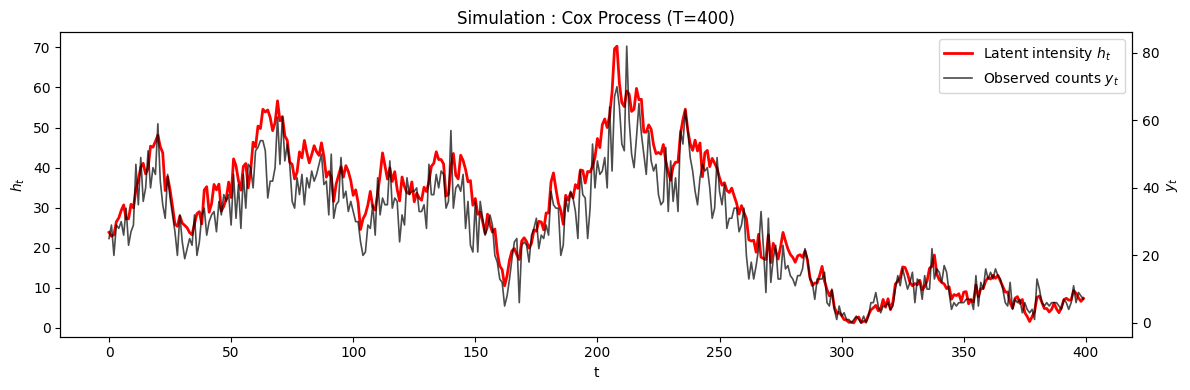

In [44]:
# pl.plot_time_series(y, h, T_show=1000, start=0, use_bars=False)
# pl.plot_histogram_h(h, nu=TRUE_PARAMS["nu"], phi=TRUE_PARAMS["phi"], c=TRUE_PARAMS["c"], burn=200)
# pl.plot_acf_h(h, lags=40, burn=200)
# pl.plot_acf_y(y, lags=40, burn=200)
pl.plot_overlay_clean(y, h, T_show=400, start=0)

## Exact filter (Creal)

In [ ]:
phi_grid = np.linspace(0.95, 0.99, 40)
ll_exact = []

f = cf.ExactFilter(y, Z_trunc=1000)

for phi in tqdm(phi_grid, desc="Exact filter over phi"):
    ll = f.log_likelihood(phi=phi, nu=2.5, c=0.2, beta=30)
    ll_exact.append(ll)

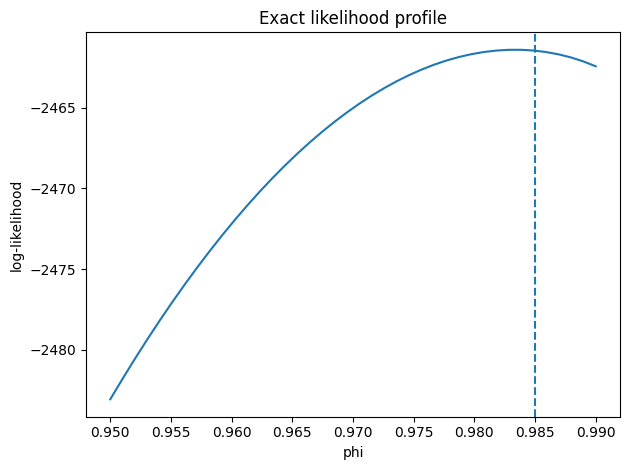

In [35]:
plt.plot(phi_grid, ll_exact)
plt.axvline(0.985, linestyle="--")
plt.xlabel("phi")
plt.ylabel("log-likelihood")
plt.title("Exact likelihood profile")
plt.tight_layout()
plt.show()

## Particle filter bootstrap

### Version implémentée 

In [46]:
particle_filter = pf.BootstrapPF(
    nu=TRUE_PARAMS["nu"],
    phi=TRUE_PARAMS["phi"],
    c=TRUE_PARAMS["c"],
    beta=TRUE_PARAMS["beta"],
    N=20000,
    seed=0,
    resample=True
)

In [47]:
ll_pf, Eh_pf = particle_filter.run(y, progress=True)

print("Bootstrap PF log-likelihood:", ll_pf)

Bootstrap PF (N=20000, seed=0): 100%|██████████| 400/400 [00:00<00:00, 411.95it/s]

Bootstrap PF log-likelihood: -1279.698585377994


### Version librairie

In [48]:
class CoxSSM(ssm.StateSpaceModel):
    def __init__(self, nu, phi, c, beta):
        self.nu = float(nu)
        self.phi = float(phi)
        self.c = float(c)        # c = SCALE du papier
        self.beta = float(beta)

    def PX0(self):
        # h0 ~ Gamma(nu, scale = c/(1-phi))
        # particles: Gamma(a, b) avec scale = 1/b  => b = (1-phi)/c
        b0 = (1.0 - self.phi) / self.c
        return dists.Gamma(self.nu, b0)

    def PX(self, t, h_prev):
        # z_t | h_{t-1} ~ Poisson(phi * h_{t-1} / c)
        z = np.random.poisson(self.phi * h_prev / self.c)

        # h_t | z_t ~ Gamma(nu+z_t, scale = c)
        # particles: b = 1/scale = 1/c
        b = 1.0 / self.c
        return dists.Gamma(self.nu + z, b)

    def PY(self, t, h_prev, h):
        # y_t | h_t ~ Poisson(beta * h_t)
        return dists.Poisson(self.beta * h)

In [49]:
np.random.seed(0)

fk = ssm.Bootstrap(
    ssm=CoxSSM(TRUE_PARAMS["nu"], TRUE_PARAMS["phi"], TRUE_PARAMS["c"], TRUE_PARAMS["beta"]),
    data=y
)

alg = particles.SMC(fk=fk, N=20000)
alg.run()

ll_pf_particles = alg.logLt
print("Bootstrap PF (particles) log-likelihood:", ll_pf_particles)

Bootstrap PF (particles) log-likelihood: -1279.604401570098


### version ancienne 

In [50]:
pf_test = pf1.loglik_pf_once(
    y,
    phi=TRUE_PARAMS["phi"],
    nu =TRUE_PARAMS["nu"],
    c=TRUE_PARAMS["c"],
    N=20000,
    seed=0,
)

In [51]:
pf_test

-1279.8660991821146

## Comparaison

In [ ]:
# SETTINGS

T = 400
TRUE_PARAMS = {"phi": 0.985, "nu": 2.5, "c": 0.2, "beta": 1}
SEED_DATA = 0

# Exact filter truncation
Z_TRUNC = 500

# Likelihood profile grid (paper spirit)
phi_grid = np.linspace(0.95, 0.999, 80)

# PF settings: compare particle counts + MC repetitions
N_list = [300, 500]     
R = 10                        # repetitions per phi (increase to 20 if time allows)
SEED0 = 123                   # base seed

OUTDIR = "figures_pf_compare"
os.makedirs(OUTDIR, exist_ok=True)

In [ ]:
#  SIMULATE ONE DATASET (fixed)

sim = cx.CoxProcessSimulation(
    T=T,
    phi=TRUE_PARAMS["phi"],
    nu=TRUE_PARAMS["nu"],
    c=TRUE_PARAMS["c"],
    seed=SEED_DATA
)

y, h_true, z_true = sim.simulate(init="stationary")
print("Sim summary: mean(y)=", float(np.mean(y)), "max(y)=", int(np.max(y)))


In [ ]:
# PARTICLES MODEL (correct Gamma rate/scale + correct PY signature)

class CoxSSM(ssm.StateSpaceModel):
    def __init__(self, nu, phi, c, beta):
        self.nu = float(nu)
        self.phi = float(phi)
        self.c = float(c)      # c = SCALE (paper)
        self.beta = float(beta)

    def PX0(self):
        # h0 ~ Gamma(nu, scale=c/(1-phi))
        # particles: Gamma(a,b) with scale = 1/b => b=(1-phi)/c
        return dists.Gamma(self.nu, (1.0 - self.phi) / self.c)

    def PX(self, t, h_prev):
        # z | h_prev ~ Poisson(phi*h_prev/c)
        z = np.random.poisson(self.phi * h_prev / self.c)
        # h | z ~ Gamma(nu+z, scale=c) => b=1/c
        return dists.Gamma(self.nu + z, 1.0 / self.c)

    def PY(self, t, h_prev, h):
        # y | h ~ Poisson(beta*h)
        return dists.Poisson(self.beta * h)

In [ ]:
# PF maison + PF particles

def loglik_pf_maison_once(y, nu, phi, c, beta, N, seed):
    particle_filter = pf.BootstrapPF(
        nu=nu, phi=phi, c=c, beta=beta,
        N=N, seed=seed, resample=True
    )
    ll, _ = particle_filter.run(y, progress=False)
    return ll

def loglik_pf_particles_once(y, nu, phi, c, beta, N, seed):
    # particles uses numpy global RNG
    np.random.seed(seed)
    fk = ssm.Bootstrap(ssm=CoxSSM(nu, phi, c, beta), data=y)
    alg = particles.SMC(fk=fk, N=N)
    alg.run()
    return alg.logLt

In [ ]:
# EXACT FILTER: warm-up + reference curve

print("\nExact filter warm-up (Numba compilation if any)...")
exact = cf.ExactFilter(y, Z_trunc=Z_TRUNC)
_ = exact.log_likelihood(
    phi=TRUE_PARAMS["phi"],
    nu=TRUE_PARAMS["nu"],
    c=TRUE_PARAMS["c"],
    beta=TRUE_PARAMS["beta"],
    return_diag=False
)

print("Computing exact likelihood curve...")
ll_exact = np.empty(phi_grid.size, dtype=float)
max_pZ_grid = np.empty(phi_grid.size, dtype=float)

for i, ph in enumerate(tqdm(phi_grid, desc="Exact LL (phi-grid)", unit="phi")):
    ll, max_pZ = exact.log_likelihood(
        phi=float(ph),
        nu=TRUE_PARAMS["nu"],
        c=TRUE_PARAMS["c"],
        beta=TRUE_PARAMS["beta"],
        return_diag=True
    )
    ll_exact[i] = ll
    max_pZ_grid[i] = max_pZ

print("max(max_pZ) over grid:", float(np.max(max_pZ_grid)))


=== Running PF for N = 300 (R=10 per phi) ===


PF evals (N=300): 100%|██████████| 1600/1600 [00:38<00:00, 41.97eval/s]


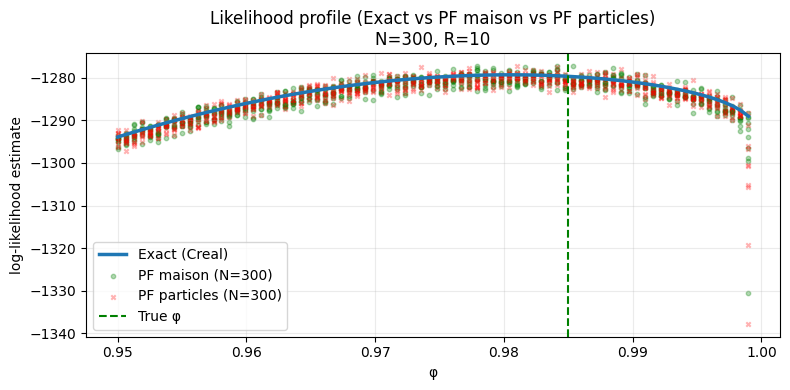

Saved: figures_pf_compare/likelihood_profile_N300_R10.png

=== Running PF for N = 500 (R=10 per phi) ===


PF evals (N=500): 100%|██████████| 1600/1600 [00:49<00:00, 32.57eval/s]


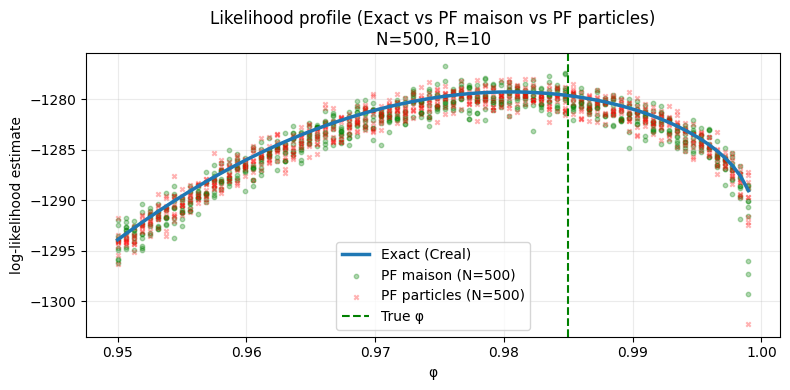

Saved: figures_pf_compare/likelihood_profile_N500_R10.png

Saved raw arrays to: figures_pf_compare/results_ll_profiles.npz


In [ ]:
#  PF: loop over N, and for each N do R repetitions per phi

results = {}  # results[N] = {"maison": mat, "particles": mat}

for N_PARTICLES in N_list:

    print(f"\n=== Running PF for N = {N_PARTICLES} (R={R} per phi) ===")

    total_evals = phi_grid.size * R * 2  # maison + particles
    ll_maison_mat = np.empty((phi_grid.size, R), dtype=float)
    ll_particles_mat = np.empty((phi_grid.size, R), dtype=float)

    with tqdm(total=total_evals, desc=f"PF evals (N={N_PARTICLES})", unit="eval") as pbar:
        for i, ph in enumerate(phi_grid):
            for r in range(R):
                seed = SEED0 + 100_000 * N_PARTICLES + 1_000 * i + r

                ll_maison_mat[i, r] = loglik_pf_maison_once(
                    y,
                    nu=TRUE_PARAMS["nu"],
                    phi=float(ph),
                    c=TRUE_PARAMS["c"],
                    beta=TRUE_PARAMS["beta"],
                    N=int(N_PARTICLES),
                    seed=seed
                )
                pbar.update(1)

                ll_particles_mat[i, r] = loglik_pf_particles_once(
                    y,
                    nu=TRUE_PARAMS["nu"],
                    phi=float(ph),
                    c=TRUE_PARAMS["c"],
                    beta=TRUE_PARAMS["beta"],
                    N=int(N_PARTICLES),
                    seed=seed
                )
                pbar.update(1)

    results[N_PARTICLES] = {"maison": ll_maison_mat, "particles": ll_particles_mat}


    #  PLOT (paper spirit): exact curve + PF clouds

    phi_scatter = np.repeat(phi_grid, R)

    plt.figure(figsize=(8, 4))
    plt.plot(phi_grid, ll_exact, lw=2.5, label="Exact (Creal)")

    plt.scatter(phi_scatter, ll_maison_mat.reshape(-1),
                s=10, alpha=0.30, color="green", label=f"PF maison (N={N_PARTICLES})")
    plt.scatter(phi_scatter, ll_particles_mat.reshape(-1),
                s=10, alpha=0.30, marker="x", color="red", label=f"PF particles (N={N_PARTICLES})")

    plt.axvline(TRUE_PARAMS["phi"], color="green", ls="--", lw=1.5, label="True φ")

    plt.xlabel("φ")
    plt.ylabel("log-likelihood estimate")
    plt.title(f"Likelihood profile (Exact vs PF maison vs PF particles)\nN={N_PARTICLES}, R={R}")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()

    fname = os.path.join(OUTDIR, f"likelihood_profile_N{N_PARTICLES}_R{R}.png")
    plt.savefig(fname, dpi=300)
    plt.show()
    plt.close()

    print("Saved:", fname)


# save raw arrays for later

np.savez(
    os.path.join(OUTDIR, "results_ll_profiles.npz"),
    phi_grid=phi_grid,
    ll_exact=ll_exact,
    max_pZ_grid=max_pZ_grid,
    **{f"ll_maison_N{N}": results[N]["maison"] for N in results},
    **{f"ll_particles_N{N}": results[N]["particles"] for N in results},
)
print("\nSaved raw arrays to:", os.path.join(OUTDIR, "results_ll_profiles.npz"))

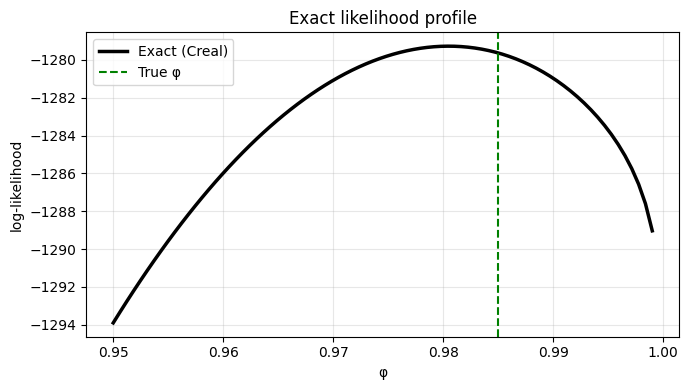

In [57]:
plt.figure(figsize=(7, 4))

plt.plot(
    phi_grid,
    ll_exact,
    linewidth=2.5,
    color="black",
    label="Exact (Creal)"
)

plt.axvline(
    TRUE_PARAMS["phi"],
    linestyle="--",
    linewidth=1.5,
    color="green",
    label="True φ"
)

plt.xlabel("φ")
plt.ylabel("log-likelihood")
plt.title("Exact likelihood profile")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

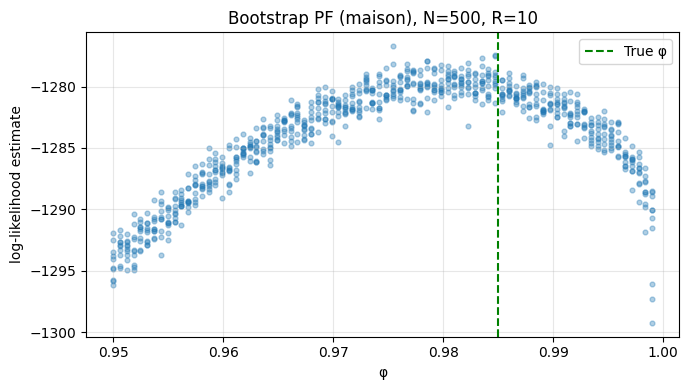

In [58]:
plt.figure(figsize=(7, 4))

plt.scatter(
    phi_scatter,
    ll_maison_mat.reshape(-1),
    s=12,
    alpha=0.35,
    color="tab:blue"
)

plt.axvline(
    TRUE_PARAMS["phi"],
    linestyle="--",
    color="green",
    linewidth=1.5,
    label="True φ"
)

plt.xlabel("φ")
plt.ylabel("log-likelihood estimate")
plt.title(f"Bootstrap PF (maison), N={N_PARTICLES}, R={R}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

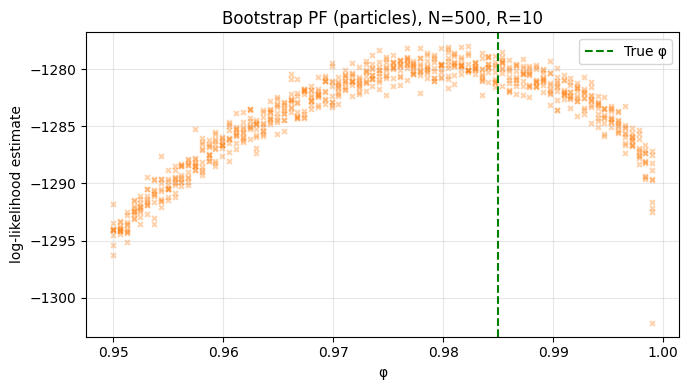

In [59]:
plt.figure(figsize=(7, 4))

plt.scatter(
    phi_scatter,
    ll_particles_mat.reshape(-1),
    s=12,
    alpha=0.35,
    marker="x",
    color="tab:orange"
)

plt.axvline(
    TRUE_PARAMS["phi"],
    linestyle="--",
    color="green",
    linewidth=1.5,
    label="True φ"
)

plt.xlabel("φ")
plt.ylabel("log-likelihood estimate")
plt.title(f"Bootstrap PF (particles), N={N_PARTICLES}, R={R}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()